<a href="https://colab.research.google.com/github/MarioAvolio/Amazon-Fine-Foods-reviews-Transformers-Text-Classification/blob/main/Amazon_Fine_Food_Text_Classification_with_Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# *So, in the spirit of Optimus Prime, let’s dive in, "transform, and roll out!"* 🤖

**Mario Avolio: 880995 - https://marioavolio.netlify.app/**

DashBoard: https://huggingface.co/MarioAvolio99/distilbert-base-uncased-finetuned-amazon-fine-food

Credits: 
- https://www.oreilly.com/library/view/natural-language-processing/9781098136789/

Dataset:
- https://snap.stanford.edu/data/web-FineFoods.html



# Data

In [ ]:
import pandas as pd
import os
import matplotlib.pyplot as plt # plotting
import numpy as np

In [ ]:
!pip uninstall transformers -y # https://github.com/huggingface/transformers/issues/22816
!pip install transformers==4.28.0
!pip install accelerate -U
from transformers import Trainer, TrainingArguments

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached transformers-4.28.0-py3-none-any.whl (7.0 MB)
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**RESTART YOUR RUNTIME AFTER THESE STEPS!** 
SEE THIS ISSUE: https://github.com/huggingface/transformers/issues/22816

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
PATH_PROJ = "/content/drive/MyDrive/data-proj/"
# if not os.path.exists(PATH_PROJ):
#   PATH_PROJ = "/content/drive/MyDrive/shared/data-proj/"

PATH_DATASET = PATH_PROJ+"food.csv"
PATH_DATASET_FIRST_PREPROCESSING = PATH_PROJ+"first_preprocessing.csv"

In [ ]:
df = pd.read_csv(PATH_DATASET_FIRST_PREPROCESSING)[["text","score"]]#.sample(frac=0.2).reset_index(drop=True) # sampling a fraction of 20% to speed process
df_tmp = df.copy()
df.rename(columns={"score": "label"}, inplace=True)
df.label = df.label-1
df

,text,label
0,I have bought several of the Vitality canned d...,4.0
1,Product arrived labeled as Jumbo Salted Peanut...,0.0
2,This is a confection that has been around a fe...,3.0
3,If you are looking for the secret ingredient i...,1.0
4,Great taffy at a great price. There was a wid...,4.0
...,...,...
35167,"Once I tasted Hazelnut coffee, I was hooked! N...",4.0
35168,Has Maxwell House quit making this coffee? I ...,4.0
35169,"Nutty, smooth, subtle, with a WONDERFUL aroma-...",4.0
35170,Price was right and the taste very good. We w...,4.0


## Looking at the Class Distribution


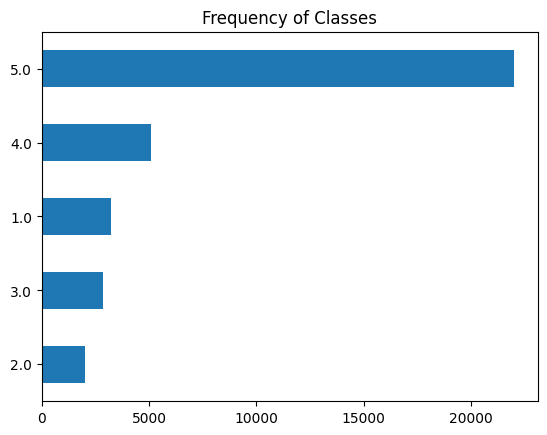

In [ ]:
import matplotlib.pyplot as plt
df_tmp["score"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

In this case, we can see that the dataset is heavily imbalanced; There are several ways to deal with imbalanced data, including:
- Randomly oversample the minority class.
- Randomly undersample the majority class.
- Gather more labeled data from the underrepresented classes.

## How Long Are Our Review?
Transformer models have a maximum input sequence length that is referred to as the
maximum context size. For applications using DistilBERT, the maximum context size
is 512 tokens, which amounts to a few paragraphs of text. 

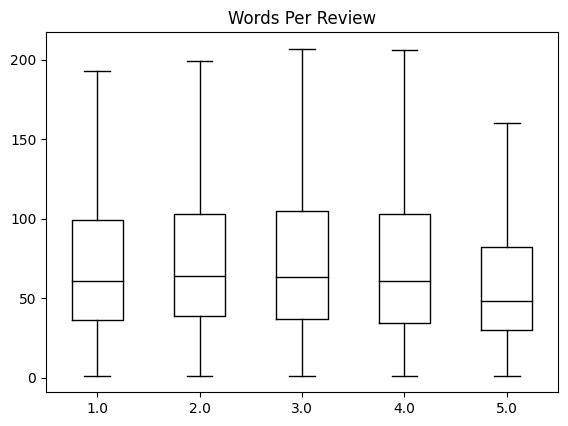

In [ ]:
df_tmp["Words Per Review"] = df_tmp["text"].str.split().apply(len)
df_tmp.boxplot("Words Per Review", by="score", grid=False,
showfliers=False, color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()
df_tmp = df_tmp.drop(["Words Per Review"], axis=1)

From the plot we see that for each emotion, most tweets are around 60 words long
and the longest tweets are well below DistilBERT’s maximum context size. Texts that
are longer than a model’s context size need to be truncated, which can lead to a loss in
performance if the truncated text contains crucial information; in this case, it looks
like that won’t be an issue.

Map target label to String
1. VERY NEGATIVE
2. NEGATIVE
3. NEUTRAL
4. POSITIVE
5. EXCELLENT


## Split

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2)

In [ ]:
train, validation = train_test_split(train, test_size=0.2)

In [ ]:
train_df = train.reset_index(drop=True)
train_df

,text,label
0,Since I have three dogs buying treats can get ...,4.0
1,THIS COFFEE IS REALLY DELICIOUS.A COOL LATIN F...,4.0
2,I'm in a gluten free diet. There are no many d...,4.0
3,"This mat is so small, and as others have noted...",1.0
4,This is the second time I have ordered from th...,4.0
...,...,...
22504,We have a family in our church that are gluten...,4.0
22505,These were NOT good. They were hard and chewy...,0.0
22506,I bought these graham sticks based on their ex...,0.0
22507,My dog is a very picky dog. So we did some re...,3.0


In [ ]:
validation_df = validation.reset_index(drop=True)
validation_df

,text,label
0,I love these but you can get 5 5.1Oz bags at ...,4.0
1,Don't buy these from Amazon Warehouse like I d...,0.0
2,I can't find dragees cheaper anywhere else. Th...,4.0
3,These chips have the right amount of crunch an...,4.0
4,This k-cup is one of my favorites along with C...,4.0
...,...,...
5623,I like to use walnut oil in salad dressings an...,4.0
5624,A few years ago I was on vacation in CA and sa...,4.0
5625,I love coffee. I love coffee a lot and really...,4.0
5626,The products are wonderful and fresh!! Everyt...,4.0


In [ ]:
test_df = test.reset_index(drop=True)
test_df

,text,label
0,Upon receiving my order for the Canidae Beef a...,3.0
1,Very quick delivery and same quality goods! C...,4.0
2,I have started buying a lot of organic food ov...,4.0
3,Switch tastes more like chemicals than juice. ...,1.0
4,This is an edit so I was unable to change my s...,3.0
...,...,...
7030,I was reading the other day about which items ...,4.0
7031,"We have two cats, both of whom can be finicky ...",3.0
7032,I am into maple syrup. I can tell the differe...,4.0
7033,"Excellent in cereal, or on top icecream sundae...",4.0


## Balancing

[]

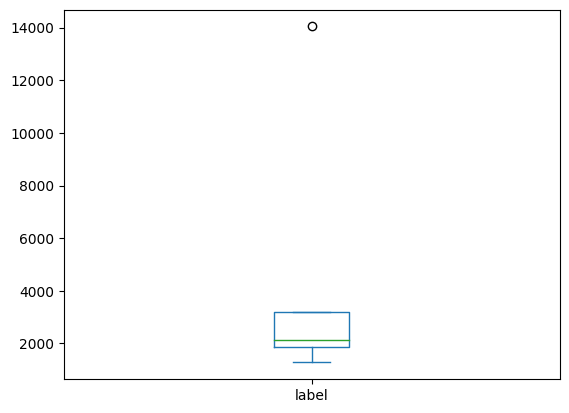

In [ ]:
b_plot = train_df.label.value_counts().plot.box() 
b_plot.plot()

In [ ]:
train_df.label.value_counts()

4.0    14041
3.0     3206
0.0     2131
2.0     1853
1.0     1278
Name: label, dtype: int64

In [ ]:
train_df.label.value_counts().describe()

count        5.00000
mean      4501.80000
std       5378.31653
min       1278.00000
25%       1853.00000
50%       2131.00000
75%       3206.00000
max      14041.00000
Name: label, dtype: float64

In [ ]:
def balance_by_label(label_value, number_of_instances, data):
  l = data[data.label == label_value].label.value_counts().to_numpy()[0]
  if l >= number_of_instances:
    return data[data.label == label_value].sample(number_of_instances, random_state=1)#.index.to_list()
  else:
    return data[data.label == label_value].sample(number_of_instances, random_state=1, replace=True)#.index.to_list()


In [ ]:
sampling_value = int(train_df.label.value_counts().describe(include='all').loc['75%']) # 75th percentiles

In [ ]:
new_train_df = balance_by_label(0, sampling_value,train_df)

for i in range(1,5):
  output = balance_by_label(i, sampling_value,train_df)  
  new_train_df = pd.concat([new_train_df, output])

new_train_df.label.value_counts()


0.0    3206
1.0    3206
2.0    3206
3.0    3206
4.0    3206
Name: label, dtype: int64

In [ ]:
train_df = new_train_df

In [ ]:
train_df = train_df[["text", "label"]].reset_index(drop=True)
train_df

,text,label
0,This is the worst flavored coffee I have ever ...,0.0
1,This is awful tasting and for the price with s...,0.0
2,"Cracker Jacks were horrible--stale, not crunch...",0.0
3,"For those of you who, like me, had to order th...",0.0
4,"First of all, I am aware that this is made for...",0.0
...,...,...
16025,This product is a quick snack very light and t...,4.0
16026,"I normally drink only Donut Shop, but when I s...",4.0
16027,"I am a true Seattle coffee addict, and I have ...",4.0
16028,My dogs love these treats. I have 3 small dogs...,4.0


## Transform into huggingface datasets

In [ ]:
!pip install datasets # https://github.com/huggingface/datasets

from datasets import Dataset
from datasets import *

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
train = Dataset.from_pandas(train_df)
# train = train.class_encode_column("label")
# print(train.features)
# Creating a ClassLabel Object

labels = ['1', '2', '3', '4', '5']
# ClassLabels = ClassLabel(num_classes=len(labels), names=labels)

# # Mapping Labels to IDs
# def map_label2id(example):
#     example['label'] = ClassLabels.str2int(example['label'])
#     return example

# train = train.map(map_label2id, batched=True)

# # Casting label column to ClassLabel Object
# train = train.cast_column('label', ClassLabels)

train = train.cast_column("label", ClassLabel(num_classes=len(labels), names=labels, names_file=None, id=None))
print(len(labels))
print(train.features)

Casting the dataset:   0%|          | 0/16030 [00:00<?, ? examples/s]

5
{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['1', '2', '3', '4', '5'], id=None)}


In [ ]:
validation = Dataset.from_pandas(validation_df).cast_column("label", ClassLabel(num_classes=len(labels),names=labels, names_file=None, id=None))
validation.features

Casting the dataset:   0%|          | 0/5628 [00:00<?, ? examples/s]

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['1', '2', '3', '4', '5'], id=None)}

In [ ]:
test = Dataset.from_pandas(test_df).cast_column("label", ClassLabel(num_classes=len(labels),names=labels, names_file=None, id=None))
test.features

Casting the dataset:   0%|          | 0/7035 [00:00<?, ? examples/s]

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['1', '2', '3', '4', '5'], id=None)}

# First form of classification

Transformers has a layered API that allows you to
interact with the library at various levels of abstraction. In this chapter we’ll start with
pipelines, which abstract away all the steps needed to convert raw text into a set of
predictions from a fine-tuned model.

In [ ]:
!pip install transformers
from transformers import pipeline
classifier = pipeline("text-classification") 
# . By default, the text-classification pipeline uses a model
# that’s designed for sentiment analysis, but it also supports multiclass and multilabel classification.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


Now that we have our pipeline, let’s generate some predictions! Each pipeline takes a
string of text (or a list of strings) as input and returns a list of predictions. Each pre‐
diction is a Python dictionary, so we can use Pandas to display them nicely as a
DataFrame:

In [ ]:
import pandas as pd
print(df.text.iloc[0])
outputs = classifier(df.text.iloc[0])
pd.DataFrame(outputs)

I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.


,label,score
0,POSITIVE,0.998385


# From Text to Token

## Subword Tokenization

In [ ]:
from transformers import AutoTokenizer
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [ ]:
encoded_text = tokenizer(train["text"][0])
print(encoded_text)

{'input_ids': [101, 2023, 2003, 1996, 5409, 14894, 2098, 4157, 1045, 2031, 2412, 2699, 1012, 2045, 2003, 2053, 23958, 2030, 14894, 1997, 7967, 1013, 20710, 2361, 9766, 2000, 2023, 4157, 14068, 2012, 2035, 1012, 1999, 2755, 1996, 4157, 16958, 14768, 1012, 1045, 2205, 2572, 3374, 1045, 2481, 1005, 1056, 4965, 2074, 1015, 6053, 1012, 2000, 3046, 2009, 2034, 1011, 1011, 2085, 1045, 2572, 5881, 2007, 2023, 9643, 4157, 1045, 3685, 2709, 1012, 2061, 1010, 17634, 2022, 8059, 1011, 1011, 2053, 5651, 999, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


We can observe three things here. First, some special [CLS] and [SEP] tokens have
been added to the start and end of the sequence. These tokens differ from model to
model, but their main role is to indicate the start and end of a sequence. Second, the
tokens have each been lowercased, which is a feature of this particular checkpoint.

Finally, we can see that some words have been split into two tokens,
which makes sense since they are not common words. In particular The ## prefix means that the preceding string is not whitespace; any token with this prefix
should be merged with the previous token when you convert the tokens back to a
string. 

In [ ]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'this', 'is', 'the', 'worst', 'flavor', '##ed', 'coffee', 'i', 'have', 'ever', 'tried', '.', 'there', 'is', 'no', 'aroma', 'or', 'flavor', 'of', 'chocolate', '/', 'ras', '##p', '##berry', 'to', 'this', 'coffee', 'bean', 'at', 'all', '.', 'in', 'fact', 'the', 'coffee', 'tastes', 'sour', '.', 'i', 'too', 'am', 'sorry', 'i', 'couldn', "'", 't', 'buy', 'just', '1', 'lb', '.', 'to', 'try', 'it', 'first', '-', '-', 'now', 'i', 'am', 'stuck', 'with', 'this', 'awful', 'coffee', 'i', 'cannot', 'return', '.', 'so', ',', 'buyer', 'be', '##ware', '-', '-', 'no', 'returns', '!', '[SEP]']


In [ ]:
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] this is the worst flavored coffee i have ever tried. there is no aroma or flavor of chocolate / raspberry to this coffee bean at all. in fact the coffee tastes sour. i too am sorry i couldn ' t buy just 1 lb. to try it first - - now i am stuck with this awful coffee i cannot return. so, buyer beware - - no returns! [SEP]


The AutoTokenizer class also has several attributes that provide information about
the tokenizer. For example, we can inspect the vocabulary size:

In [ ]:
tokenizer.vocab_size

30522

and the corresponding model’s maximum context size:


In [ ]:
tokenizer.model_max_length

512

Another interesting attribute to know about is the names of the fields that the model
expects in its forward pass:

In [ ]:
tokenizer.model_input_names

['input_ids', 'attention_mask']

## Tokenizing the Whole Dataset
To tokenize the whole corpus, we’ll use the map() method of our DatasetDict object.

To get started, the first thing we need is a processing function to tokenize our examples with:

In [ ]:
def tokenize(batch):
  '''
  This function applies the tokenizer to a batch of examples; padding=True will pad the
  examples with zeros to the size of the longest one in a batch, and truncation=True
  will truncate the examples to the model’s maximum context size.
  '''
  return tokenizer(batch["text"], padding=True, truncation=True)

In [ ]:
encoded_text = tokenize(train[:2])
encoded_text

{'input_ids': [[101, 2023, 2003, 1996, 5409, 14894, 2098, 4157, 1045, 2031, 2412, 2699, 1012, 2045, 2003, 2053, 23958, 2030, 14894, 1997, 7967, 1013, 20710, 2361, 9766, 2000, 2023, 4157, 14068, 2012, 2035, 1012, 1999, 2755, 1996, 4157, 16958, 14768, 1012, 1045, 2205, 2572, 3374, 1045, 2481, 1005, 1056, 4965, 2074, 1015, 6053, 1012, 2000, 3046, 2009, 2034, 1011, 1011, 2085, 1045, 2572, 5881, 2007, 2023, 9643, 4157, 1045, 3685, 2709, 1012, 2061, 1010, 17634, 2022, 8059, 1011, 1011, 2053, 5651, 999, 102, 0], [101, 2023, 2003, 9643, 18767, 1998, 2005, 1996, 3976, 2007, 7829, 2357, 2041, 2000, 2022, 1002, 2184, 1037, 5835, 1012, 4149, 2005, 2026, 2365, 1005, 1055, 5798, 2283, 1998, 2070, 1997, 1996, 3337, 2020, 16405, 6834, 1998, 18201, 2075, 2009, 2001, 2061, 2919, 1012, 2017, 2024, 2488, 2125, 9343, 1037, 5835, 1997, 21310, 2980, 12901, 1998, 14684, 12588, 2009, 2091, 1012, 1012, 1012, 2012, 2560, 2009, 16958, 2204, 1012, 2023, 2001, 2026, 5221, 10973, 1011, 2125, 4965, 2412, 999, 999, 99

the first element of input_ids is longer than
the second, so zeros have been added to that element to make them the same length.
These zeros have a corresponding [PAD] token in the vocabulary, and the set of special tokens also includes the [CLS] and [SEP] tokens that we encountered earlier:

In [ ]:
tokenizer.convert_ids_to_tokens(encoded_text.input_ids[1])

['[CLS]',
 'this',
 'is',
 'awful',
 'tasting',
 'and',
 'for',
 'the',
 'price',
 'with',
 'shipping',
 'turned',
 'out',
 'to',
 'be',
 '$',
 '10',
 'a',
 'bottle',
 '.',
 'bought',
 'for',
 'my',
 'son',
 "'",
 's',
 'birthday',
 'party',
 'and',
 'some',
 'of',
 'the',
 'boys',
 'were',
 'pu',
 '##king',
 'and',
 'gag',
 '##ing',
 'it',
 'was',
 'so',
 'bad',
 '.',
 'you',
 'are',
 'better',
 'off',
 'buying',
 'a',
 'bottle',
 'of',
 'franks',
 'hot',
 'sauce',
 'and',
 'chu',
 '##gging',
 'it',
 'down',
 '.',
 '.',
 '.',
 'at',
 'least',
 'it',
 'tastes',
 'good',
 '.',
 'this',
 'was',
 'my',
 'biggest',
 'rip',
 '-',
 'off',
 'buy',
 'ever',
 '!',
 '!',
 '!',
 '[SEP]']

Also note that in addition to returning the encoded tweets as input_ids, the tokenizer returns a list of attention_mask arrays. This is because we do not want the
model to get confused by the additional padding tokens: the attention mask allows
the model to ignore the padded parts of the input.

Once we’ve defined a processing function, we can apply it across all the splits in the
corpus in a single line of code:

In [ ]:
train = train.map(tokenize, batched=True, batch_size=None)
validation = validation.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/16030 [00:00<?, ? examples/s]

Map:   0%|          | 0/5628 [00:00<?, ? examples/s]

By default, the map() method operates individually on every example in the corpus,
so setting batched=True will encode the tweets in batches. Because we’ve set
batch_size=None, our tokenize() function will be applied on the full dataset as a
single batch. This ensures that the input tensors and attention masks have the same
shape globally, and we can see that this operation has added new input_ids and
attention_mask columns to the dataset

In [ ]:
train.column_names

['text', 'label', 'input_ids', 'attention_mask']

In [ ]:
validation.column_names

['text', 'label', 'input_ids', 'attention_mask']

# Training a Text Classifier
First, the text is tokenized and represented as one-hot vectors called token encodings.
The size of the tokenizer vocabulary determines the dimension of the token encodings, and it usually consists of 20k–200k unique tokens. Next, these token encodings
are converted to token embeddings, which are vectors living in a lower-dimensional
space. The token embeddings are then passed through the encoder block layers to
yield a hidden state for each input token. For the pretraining objective of language
modeling, each hidden state is fed to a layer that predicts the masked input tokens.
For the classification task, we replace the language modeling layer with a classification layer

## Transformers as Feature Extractors
Using a transformer as a feature extractor is fairly simple. Freeze the body’s weights during training and use the hidden states as features for the
classifier. The advantage of this approach is that we can quickly train a small or shallow model.


### Using pretrained models


In [ ]:
import torch
from transformers import AutoModel

model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


The AutoModel class converts the token encodings to embeddings, and then feeds
them through the encoder stack to return the hidden states. Let’s take a look at how
we can extract these states from our corpus.

### Extracting the last hidden states

To warm up, let’s retrieve the last hidden states for a single string. The first thing we
need to do is encode the string and convert the tokens to PyTorch tensors. This can
be done by providing the return_tensors="pt" argument to the tokenizer as follows:

In [ ]:
text = train["text"][:1]
print(text)
inputs = tokenizer(text, return_tensors="pt")
print(f"Input tensor shape: {inputs['input_ids'].size()}")
inputs.items()

["This is the worst flavored coffee I have ever tried.  There is no aroma or flavor of Chocolate/Raspberry to this coffee bean at all.  In fact the coffee tastes sour.  I too am sorry I couldn't buy just 1 lb. to try it first -- Now I am stuck with this awful coffee I cannot return.  SO, BUYER BEWARE -- NO RETURNS!"]
Input tensor shape: torch.Size([1, 81])


dict_items([('input_ids', tensor([[  101,  2023,  2003,  1996,  5409, 14894,  2098,  4157,  1045,  2031,
          2412,  2699,  1012,  2045,  2003,  2053, 23958,  2030, 14894,  1997,
          7967,  1013, 20710,  2361,  9766,  2000,  2023,  4157, 14068,  2012,
          2035,  1012,  1999,  2755,  1996,  4157, 16958, 14768,  1012,  1045,
          2205,  2572,  3374,  1045,  2481,  1005,  1056,  4965,  2074,  1015,
          6053,  1012,  2000,  3046,  2009,  2034,  1011,  1011,  2085,  1045,
          2572,  5881,  2007,  2023,  9643,  4157,  1045,  3685,  2709,  1012,
          2061,  1010, 17634,  2022,  8059,  1011,  1011,  2053,  5651,   999,
           102]])), ('attention_mask', tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1]]))])

As we can see, the resulting tensor has the shape [batch_size, n_tokens]. Now that
we have the encodings as a tensor, the final step is to place them on the same device
as the model and pass the inputs as follows

In [ ]:
inputs = {k:v.to(device) for k,v in inputs.items()}

# Here we’ve used the torch.no_grad() context manager to disable the automatic calculation of the gradient.
# This is useful for inference since it reduces the memory foot print of the computations. 
with torch.no_grad(): 
  outputs = model(**inputs) # ** pass a variable number keyword arguments (keys and values.)
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.1472,  0.2240,  0.2020,  ...,  0.0567,  0.4314,  0.3544],
         [-0.3063,  0.1798,  0.0268,  ..., -0.2561,  0.5712,  0.2284],
         [-0.7484,  0.3160,  0.2314,  ...,  0.0451,  0.3046,  0.7739],
         ...,
         [-0.1113,  0.3902,  0.7727,  ...,  0.0176, -0.2629, -0.4603],
         [ 0.1589,  0.2733,  0.1939,  ...,  0.2870,  0.2752, -0.0717],
         [-0.2919,  0.7891,  0.5657,  ...,  0.5790,  0.3533,  0.0234]]],
       device='cuda:0'), hidden_states=None, attentions=None)


In [ ]:
outputs.last_hidden_state.size()

torch.Size([1, 81, 768])

Looking at the hidden state tensor, we see that it has the shape [batch_size,
n_tokens, hidden_dim]. In other words, a 768-dimensional vector is returned for
each of the input tokens.

For classification tasks, it is common practice to just use
the hidden state associated with the [CLS] token as the input feature. Since this token
appears at the start of each sequence, we can extract it by simply indexing into
outputs.last_hidden_state as follows

In [ ]:
outputs.last_hidden_state[:,0].size()

torch.Size([1, 768])

Now we know how to get the last hidden state for a single string; let’s do the same for
the whole dataset by creating a new hidden_state column that stores all these vectors

In [ ]:
def extract_hidden_states(batch):
  # Place model inputs on the GPU
  inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}

  # Extract last hidden states
  with torch.no_grad():
    last_hidden_state = model(**inputs).last_hidden_state

  # Return vector for [CLS] token
  return {"hidden_state": last_hidden_state[:,0].cpu().numpy()} # we place the final hidden state back on the CPU as a NumPy array
  # The map() method requires the processing function to return Python or NumPy objects when
  # we’re using batched inputs.

Since our model expects tensors as inputs, the next thing to do is convert the
input_ids and attention_mask columns to the "torch" format, as follows:

In [ ]:
train.set_format("torch", columns=["input_ids", "attention_mask", "label"])
validation.set_format("torch", columns=["input_ids", "attention_mask", "label"])

train, validation

(Dataset({
     features: ['text', 'label', 'input_ids', 'attention_mask'],
     num_rows: 16030
 }),
 Dataset({
     features: ['text', 'label', 'input_ids', 'attention_mask'],
     num_rows: 5628
 }))

We can then go ahead and extract the hidden states across all splits in one go:


In [ ]:
train = train.map(extract_hidden_states, batched=True, batch_size=256)

Map:   0%|          | 0/16030 [00:00<?, ? examples/s]

In [ ]:
train.column_names

Now we can execute the same process to the validation set

In [ ]:
validation = validation.map(extract_hidden_states, batched=True, batch_size=256)
validation.column_names

Now that we have the hidden states associated with each review, the next step is to
train a classifier on them. To do that, we’ll need a feature matrix let’s take a look.

### Creating a feature matrix
The preprocessed dataset now contains all the information we need to train a classifier on it. We will use the hidden states as input features and the labels as targets. We
can easily create the corresponding arrays in the well-known Scikit-learn format as
follows:


In [ ]:
import numpy as np
X_train = np.array(train["hidden_state"])
X_valid = np.array(validation["hidden_state"])
y_train = np.array(train["label"])
y_valid = np.array(validation["label"])
X_train.shape, X_valid.shape

### Visualizing the training set
Before we train a model on the hidden states, it’s good practice to perform a quick
check to ensure that they provide a useful representation of the emotions we want to classify. Since visualizing the hidden states in 768 dimensions is tricky to say the least, we’ll
use the powerful UMAP algorithm to project the vectors down to 2D (https://arxiv.org/abs/1802.03426) . Since UMAP
works best when the features are scaled to lie in the [0,1] interval, we’ll first apply a
MinMaxScaler and then use the UMAP implementation from the umap-learn library
to reduce the hidden states:

In [ ]:
!pip uninstall umap
!pip install umap-learn 
# # https://umap-learn.readthedocs.io/en/latest/
# !pip install umap-learn[plot]
# !pip install holoviews
# !pip install -U ipykernel


In [ ]:
# # https://umap-learn.readthedocs.io/en/latest/

# for any problem you can consult this link https://github.com/lmcinnes/umap/issues/828
import umap.umap_ as umap
from umap.umap_ import UMAP
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# Scale features to [0,1] range
X_scaled = MinMaxScaler().fit_transform(X_train)

# Initialize and fit UMAP
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)

# Create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

The result is an array with the same number of training samples, but with only 2 features instead of the 768 we started with! Let’s investigate the compressed data a little
bit further and plot the density of points for each category separately:

In [ ]:
df_emb.query(f"label == {1.0}")

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(7,5))
axes = axes.flatten()
cmaps = ["Greens", "Blues", "Oranges", "Reds", "Purples"]
labels = train.features["label"].names


for i, (label, cmap) in enumerate(zip(labels, cmaps)):
  df_emb_sub = df_emb.query(f"label == {label}")
  axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap, gridsize=20, linewidths=(0,))
  axes[i].set_title(f"score: {label}")
  axes[i].set_xticks([]), axes[i].set_yticks([])
plt.tight_layout()  
plt.show()

These are only projections onto a lower-dimensional space. Just
because some categories overlap does not mean that they are not
separable in the original space. Conversely, if they are separable in
the projected space they will be separable in the original space.

From this plot we can see some clear patterns: the hight labels such as 4 and 5 are well separated from the other labels and also
share a similar space. On the other hand lower labels such as 1 and 2 all occupy different regions and has different distribution, for example label 2 scattered all over the place.Finally, the neutral label (3) occupies similar regions occupied by the highs but has a distribution more similar to those of the lower labels.

Although we
may have hoped for some separation, this is in no way guaranteed since the model
was not trained to know the difference between these labels. It only learned them
implicitly by guessing the masked words in texts.

### Training a simple classifier

We’ve seen that the hidden states are somewhat different between the labels,
although for several of them there is no obvious boundary. Let’s use these hidden
states to train a logistic regression model with Scikit-learn. 

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report



def svm_classifier(X_train_balanced, y_train_balanced, X_ts, y_ts):
  classifier = LinearSVC() 
  classifier.fit(X_train_balanced, y_train_balanced) #fit the model with training data
  y_pred_class = classifier.predict(X_ts)
  analisys(y_ts, y_pred_class)

def mnb_classifier(X_train_balanced, y_train_balanced, X_ts, y_ts):
  nb = MultinomialNB() #instantiate a Multinomial Naive Bayes classifier
  nb.fit(X_train_balanced, y_train_balanced)#train the mode
  y_pred_class = nb.predict(X_ts)#make class predictions for test data
  analisys(y_ts, y_pred_class)

def lr_classifier(X_train_balanced, y_train_balanced, X_ts, y_ts):
  logreg = LogisticRegression(max_iter=10000)
  logreg.fit(X_train_balanced, y_train_balanced)
  y_pred_class = logreg.predict(X_ts)
  analisys(y_ts, y_pred_class)


In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
  cm = confusion_matrix(y_true, y_preds, normalize="true")
  fig, ax = plt.subplots(figsize=(6, 6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
  plt.title("Normalized confusion matrix")
  plt.show()


In [ ]:
def analisys(y_test, y_pred_class):
  print("\n Accuracy: ", accuracy_score(y_test, y_pred_class))
  print("Report: \n",classification_report(y_test, y_pred_class))
  plot_confusion_matrix(y_pred_class, y_valid, labels)

#### Logistic Regression


In [ ]:
%%script false --no-raise-error

lr_classifier(X_train, y_train, X_valid, y_valid)

#### Support Vector Machine


In [ ]:
%%script false --no-raise-error

svm_classifier(X_train, y_train, X_valid, y_valid)

Looking at the accuracy, it might appear that our model is just a bit better than random. We can examine whether our model is any good by comparing it
against a simple baseline. In Scikit-learn there is a DummyClassifier that can be used
to build a classifier with simple heuristics such as always choosing the majority class
or always drawing a random class. In this case the best-performing heuristic is to
always choose the most frequent class, which yields an accuracy of about 62%:

In [ ]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

So, our simple classifier with DistilBERT embeddings is not much better than our
baseline. We can further investigate the performance of the model by looking at the
confusion matrix of the classifier, which tells us the relationship between the true and
predicted labels:

We can see that our model tends to overstimate the class of 5 label. As we seen in the observation we made when visualizing the embeddings, the classes 4 and 5 occupies similar regions, infact class 4 is confused with class 5.

At the same time class 2 is sometimes confused with class 1. 

## Fine-Tuning Transformers
Let’s now explore what it takes to fine-tune a transformer end-to-end. With the finetuning approach we do not use the hidden states as fixed features, but instead train them.

### Loading a pretrained model
The first thing we need is a pretrained DistilBERT model like the one we used in the
feature-based approach. The only slight modification is that we use the AutoModelFor
SequenceClassification model instead of AutoModel. The difference is that the
AutoModelForSequenceClassification model has a classification head on top of the
pretrained model outputs, which can be easily trained with the base model. We just
need to specify how many labels the model has to predict (five in our case), since this
dictates the number of outputs the classification head has:

In [ ]:
from transformers import AutoModelForSequenceClassification
num_labels = 5
model = (AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels).to(device))

### Defining the performance metrics

To monitor metrics during training, we need to define a compute_metrics() function
for the Trainer. This function receives an EvalPrediction object (which is a named
tuple with predictions and label_ids attributes) and needs to return a dictionary
that maps each metric’s name to its value. For our application, we’ll compute the
F
1-label and the accuracy of the model as follows:

In [ ]:
from sklearn.metrics import accuracy_score, f1_score
def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels, preds, average="weighted")
  acc = accuracy_score(labels, preds)
  return {"accuracy": acc, "f1": f1}

### Training the model


In [ ]:
from huggingface_hub import notebook_login

In [ ]:
notebook_login()


To define the training parameters, we use the TrainingArguments class. This class
stores a lot of information and gives you fine-grained control over the training and
evaluation. The most important argument to specify is output_dir, which is where
all the artifacts from training are stored.

In [ ]:
from transformers import Trainer, TrainingArguments

batch_size = 32
logging_steps = len(train) // batch_size
model_name = f"{model_ckpt}-finetuned-amazon-fine-food"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=True, 
                                  log_level="error")
     

Here we also set the batch size, learning rate, and number of epochs, and specify to
load the best model at the end of the training run. With this final ingredient, we can
instantiate and fine-tune our model with the Trainer:

In [ ]:
from transformers import Trainer

# train = train.rename_column("label", "labels")
# validation = validation.rename_column("label", "labels")

trainer = Trainer(model=model, args=training_args, 
                  compute_metrics=compute_metrics,
                  train_dataset=train,
                  eval_dataset=validation,
                  tokenizer=tokenizer)

trainer.train()

In [ ]:
# The output of the predict() method is a PredictionOutput object that contains
# arrays of predictions and label_ids, along with the metrics we passed to the
# trainer.
preds_output = trainer.predict(validation) 


In [ ]:
preds_output.metrics


In [ ]:
y_preds = np.argmax(preds_output.predictions, axis=1)

In [ ]:
plot_confusion_matrix(y_preds, y_valid)

### Error analysis


In [ ]:
from torch.nn.functional import cross_entropy


In [ ]:
def forward_pass_with_label(batch):
  # Place all input tensors on the same device as the model
  inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}
  with torch.no_grad():
    output = model(**inputs)
    pred_label = torch.argmax(output.logits, axis=-1)
    loss = cross_entropy(output.logits, batch["label"].to(device),
    reduction="none")
  
  # Place outputs on CPU for compatibility with other dataset columns
  return {"loss": loss.cpu().numpy(), "predicted_label": pred_label.cpu().numpy()}


we can apply this function to get the losses for all
the samples

In [ ]:
# Convert our dataset back to PyTorch tensors
# validation.set_format("torch", columns=["input_ids", "attention_mask", "label"])
test.set_format("torch", columns=["input_ids", "attention_mask", "label"])

In [ ]:
# Compute loss values
test = test.map(forward_pass_with_label, batched=True, batch_size=16)

Finally, we create a DataFrame with the texts, losses, and predicted/true labels:


In [ ]:
emotions_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = test[:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"].apply(label_int2str))

We can now easily sort emotions_encoded by the losses in either ascending or
descending order. The goal is to detect the following:
- **Wrong labels**: Every process that adds labels to data can be flawed. Annotators can make mistakes or disagree, while labels that are inferred from other features can be wrong.
If it was easy to automatically annotate data, then we would not need a model to
do it. Thus, it is normal that there are some wrongly labeled examples. With this
approach, we can quickly find and correct them.
- **Quirks of the dataset**: Datasets in the real world are always a bit messy. When working with text, special
characters or strings in the inputs can have a big impact on the model’s predictions. Inspecting the model’s weakest predictions can help identify such features,
and cleaning the data or injecting similar examples can make the model more
robust

In [ ]:
df_test.sort_values("loss", ascending=False).head(10)

In [ ]:
df_test.sort_values("loss", ascending=True).head(10)


### Saving and sharing the model


In [ ]:
trainer.push_to_hub(commit_message="Training completed!")
from transformers import pipeline
model_id = "MarioAvolio99/distilbert-base-uncased-finetuned-amazon-fine-food"
classifier = pipeline("text-classification", model=model_id)

def classify_my_review(custom_review):
  preds = classifier(custom_review, return_all_scores=True)

  preds_df = pd.DataFrame(preds[0])
  plt.bar(labels, 100 * preds_df["score"], color='C0')
  plt.title(f'"{custom_review}"')
  plt.ylabel("Class probability (%)")
  plt.show()

In [ ]:
# 4/5
custom_review = "Couple of visible marks but using a cover and screen protectors so not a big deal. Got two of these 87%and 80% on the other happy so far battery lasts a day so all good"
classify_my_review(custom_review)

In [ ]:
# 3/5
custom_review = "Cat will not sleep in it. Let's try and persevere."
classify_my_review(custom_review)

In [ ]:
# 5/5
custom_review = "Best pets brush I have ever used. Just after using all you need to do is press a button and all pet hair is ejected."
classify_my_review(custom_review)

In [ ]:
# 1/5
custom_review = "Doesn't help with the tangles at all"
classify_my_review(custom_review)

In [ ]:
# 2/5
custom_review = "The filter should not be dried. If once it dried for some time then performance will go down. It will take long time to filter water."
classify_my_review(custom_review)